# Log-Normal Mocks for DESI LRGs

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import fitsio as ft
import healpy as hp
from glob import glob
import sys
sys.path.append('/home/mehdi/github/LSSutils')
from lssutils.dataviz import setup_color
from lssutils.utils import histogram_cell, maps_dr9, make_hp
from lssutils.stats.window import WindowSHT

In [3]:
setup_color()

## Redshift Distribution

Text(0.5, 0, 'redshift')

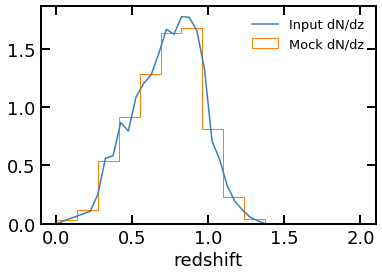

In [5]:
input_nz = np.loadtxt('/home/mehdi/github/flask/data/desi-z-selection-f1.dat')
catalog = ft.read('/home/mehdi/data/lognormal/lrg-cat-100.fits')
np.diff(input_nz[:, 0])

plt.plot(input_nz[:, 0], input_nz[:, 1]/(input_nz[:, 1].sum()*0.05), label='Input dN/dz')
plt.hist(catalog['z'], histtype='step', density=True, label='Mock dN/dz')

plt.legend()
plt.xlabel('redshift')

In [3]:
den_field = hp.read_map('/home/mehdi/data/lognormal/v0/lrg-88-f1z1.fits', verbose=False)

nside = 256


# nbar_sqdeg = 800. # per sq. deg
# nbar_sr = nbar_sqdeg * (180./np.pi)**(2)
# noise = 1./nbar_sr
# noise

den_contrast = den_field/den_field.mean() - 1.0
cl_obs = hp.anafast(den_contrast)
noise = hp.nside2pixarea(nside)/den_field.mean()
noise

5.247718593589074e-07

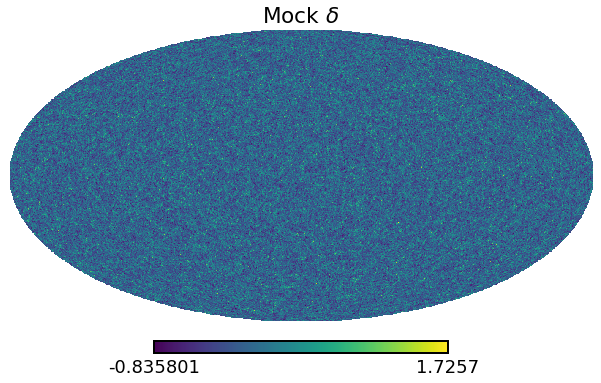

In [5]:
hp.mollview(den_contrast, title=r'Mock $\delta$')

Text(0.5, 0, 'Mock $\\delta$')

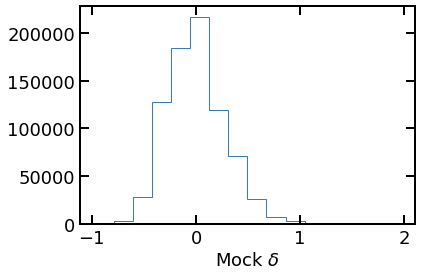

In [4]:
_ = plt.hist(den_contrast, histtype='step', bins=16)
plt.xlabel(r'Mock $\delta$')

## Power Spectra

In [4]:
cl_dr9 = np.load('/home/mehdi/data/rongpu/imaging_sys/clustering/v2/cl_lrg_bmzls_256_nn.npy', 
                allow_pickle=True).item()
cl_model = np.loadtxt('/home/mehdi/github/flask/data/desiCl-f1z1f1z1.dat')

list_clmocks = glob('/home/mehdi/data/lognormal/v0/clustering/clmock_*_lrg_bmzls_256_noweight.npy')
len(list_clmocks)

cl_mocks = []

for fl in list_clmocks:
    cl_i = np.load(fl, allow_pickle=True).item()
    cl_mocks.append(cl_i['cl_gg']['cl'])
    print('.', end='')
    
cl_min, cl_max = np.percentile(cl_mocks, [15, 85], axis=0)
cl_mocks_mean = np.mean(cl_mocks, axis=0)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [5]:
# mask

dt = ft.read('/home/mehdi/data/rongpu/imaging_sys/tables/nlrg_features_bmzls_256.fits')
mask_ = make_hp(256, dt['hpix'], 1.0) > 0.5
mask = hp.ud_grade(mask_, 1024)
weight = mask * 1.0

noise = 5.247718593589074e-07
el_m = np.arange(2*1024)
wd = WindowSHT(weight, mask, el_m, ngauss=2*1024)
cl_model_noise = cl_model[:, 1]+noise
cl_model_wind_noise = wd.convolve(cl_model[:, 0], cl_model[:, 1])+noise

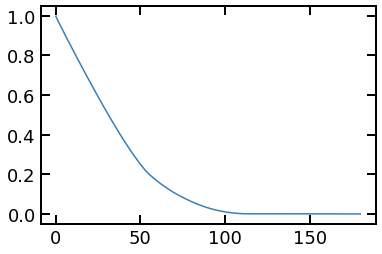

In [6]:
plt.plot(np.arccos(wd.x)*180./np.pi, wd.xi_mask)
# plt.xscale('log')
# plt.yscale('log')

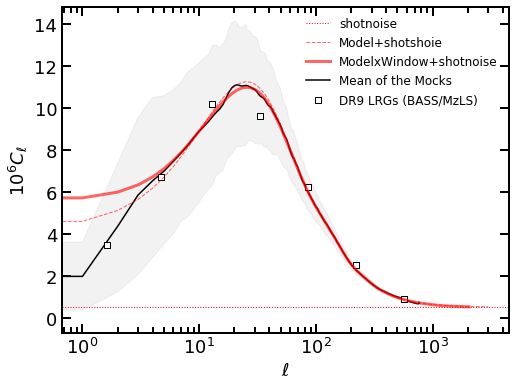

In [7]:
plt.figure(figsize=(8, 6))

# model
plt.axhline(noise, color='r', ls=':', lw=1, label='shotnoise')
plt.plot(cl_model_noise, 'r--', lw=1, alpha=0.6, label='Model+shotshoie')
plt.plot(cl_model_wind_noise, 'r-', lw=3, alpha=0.6, label='ModelxWindow+shotnoise')

# mocks
plt.plot(cl_mocks_mean, color='k', label='Mean of the Mocks', zorder=-1)
# for cl_mock_i in cl_mocks:
#     plt.plot(cl_mock_i, color='grey', lw=1, ls='-', alpha=0.02, zorder=-10)
plt.fill_between(np.arange(cl_min.size), cl_min, cl_max, alpha=0.1, color='grey', zorder=-10)


# data
plt.scatter(*histogram_cell(cl_dr9['cl_gg']['cl'], bins=np.logspace(0, np.log10(769), 8)),
            marker='s', facecolor='w', 
            color='k', label='DR9 LRGs (BASS/MzLS)')


plt.legend(fontsize=12) #, bbox_to_anchor=(1., 1.2))
# plt.ylim(1.0e-8, 1.0e-4)
# plt.yscale('log')
plt.yticks([i*2.0e-6 for i in range(8)], labels=[f'{2*i}' for i in range(8)])
plt.ylabel(r'$10^{6}C_{\ell}$')
plt.xlabel(r'$\ell$')
plt.xscale('log')

In [8]:
lbins = np.arange(1, 769, 50)
l_obs, cl_obs = histogram_cell(cl_dr9['cl_gg']['cl'], bins=lbins)


cl_mb = []

for cl_i in cl_mocks:
    cl_ib = histogram_cell(cl_i, bins=lbins)[1] 
    cl_mb.append(cl_ib)

clb_min, clb_max = np.percentile(cl_mb, [15, 85], axis=0)
clb_mean = np.mean(cl_mb, axis=0)

In [9]:
clb_model = histogram_cell(cl_model_wind_noise, bins=lbins)[1]

(0.5, 1.5)

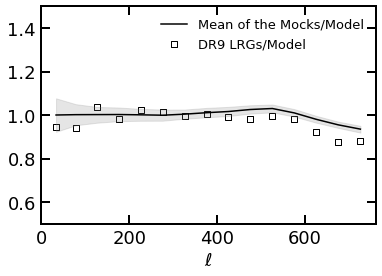

In [10]:
plt.scatter(l_obs, cl_obs/clb_model, marker='s', facecolor='w', 
            color='k', label='DR9 LRGs/Model')
plt.plot(l_obs, clb_mean/clb_model, color='k', label='Mean of the Mocks/Model')

plt.fill_between(l_obs, clb_min/clb_model, clb_max/clb_model, alpha=0.2, color='grey')

plt.legend()
plt.xlabel(r'$\ell$')
plt.ylim(0.5, 1.5)

## Mean Density

In [169]:
def read_nnbar(filename, indices=None):
    
    d_i = np.load(filename, allow_pickle=True)    
    err_mat = []
    extremes = []
    
    if indices is not None:            
        for i, d_ij in enumerate(d_i):
            if i in indices:
                err_mat.append(d_ij['nnbar']-1.0)
                extremes.append([d_ij['nnbar'][0], d_ij['nnbar'][-1]])
            else:
                continue
    else:
        for i, d_ij in enumerate(d_i):
            err_mat.append(d_ij['nnbar']-1.0)
            extremes.append([d_ij['nnbar'][0], d_ij['nnbar'][-1]])

            
    return np.array(err_mat).flatten(), np.array(extremes)

def chi2_fn(y, invcov):
    return np.dot(y, np.dot(invcov, y))  


def read_nbmocks(list_nbars, indices=None):
    
    err_mat = []
    
    for nbar_i in list_nbars:
        
        err_i,  = read_nnbar(nbar_i, indices=None)
        err_mat.append(err_i)
        print('.', end='')

    err_mat = np.array(err_mat)
    print(err_mat.shape)
    return err_mat

In [170]:
list_nbars = glob('/home/mehdi/data/lognormal/v0/clustering/nbarmock_*_lrg_bmzls_256_noweight.npy')
len(list_nbars)

1000

In [176]:
for nbar_i in list_nbars[:1]:
    d_ = np.load(nbar_i, allow_pickle=True)
    for d_i in d_:
        #print(d_i['bin_avg'])
        print(d_i['nnbar'])

[0.99585615 1.00197567 0.99586151 1.00315507 1.00664504 0.9914709
 1.00287094 1.00216488]
[1.00504748 1.00004841 1.00143421 1.00017171 1.00245011 0.99759846
 0.99122162 1.00202817]
[0.99079275 0.9991987  1.00173978 1.00263238 0.99719371 1.0004612
 1.00130019 1.00668184]
[0.99960345 1.00532625 1.00176391 0.99845889 1.00048264 0.99945602
 1.00220083 0.99270741]
[1.00152535 1.00037543 0.99682648 1.00201855 0.99702752 1.00374478
 1.00050677 0.99797496]
[0.9910742  0.99823105 1.0032891  0.99740278 1.00542543 0.99882879
 1.00227856 1.00347038]
[0.99927911 1.00654051 1.00461861 0.99925499 0.9993354  0.99735454
 0.99911292 0.99450347]
[1.00370993 0.99503861 0.99683184 0.99638421 1.00513862 1.00375014
 1.00246351 0.99668287]
[0.99855807 0.99625554 1.00393777 1.00577121 0.99979644 0.99558006
 0.99915313 1.00094785]
[0.9986358  0.99436045 1.0041388  1.00757249 0.99920674 0.99348126
 1.00252784 1.00007662]
[0.9947384  1.00194082 0.99872694 1.00046924 0.99747248 1.00594544
 1.00497511 0.99573123]
[

In [171]:
err_mat = read_nbmocks(list_nbars)


err_0 = read_nnbar('/home/mehdi/data/rongpu/imaging_sys/clustering/v2/nbar_lrg_bmzls_256_noweight.npy')
err_1 = read_nnbar('/home/mehdi/data/rongpu/imaging_sys/clustering/v2/nbar_lrg_bmzls_256_nn.npy')

nmocks, nbins = err_mat.shape
hartlapf = (nmocks - 1.) / (nmocks - nbins - 2.)
covmax = np.cov(err_mat, rowvar=False)*hartlapf
invcov = np.linalg.inv(covmax)


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [163]:
np.percentile(covmax.dot(invcov), [1, 99])

array([-5.43870504e-15,  1.00000000e+00])

In [155]:
np.percentile(covmax.dot(invcov), [1, 99])

array([-5.73872547e-15,  1.00000000e+00])

In [165]:
np.percentile(invcov, [1, 99])

array([-1067634.54501887,  1098561.94196371])

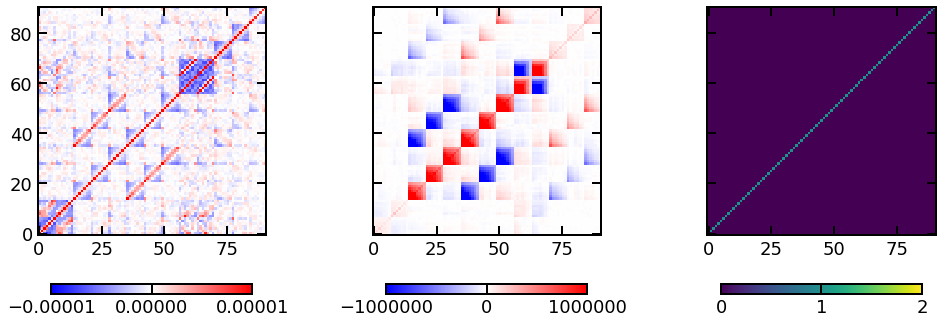

In [168]:
fg, ax = plt.subplots(ncols=3, figsize=(18, 6), sharey=True)
fg.subplots_adjust(wspace=0.0, hspace=0.0)

map0 = ax[0].imshow(covmax, origin='lower', cmap=plt.cm.bwr, vmin=-1.0e-5, vmax=1.0e-5)
fg.colorbar(map0, ax=ax[0], orientation='horizontal', ticks=[-1.0e-5, 0, 1.0e-5], shrink=0.6)

map1 = ax[1].imshow(invcov, origin='lower', cmap=plt.cm.bwr, vmin=-1.0e6, vmax=1.0e6,)
fg.colorbar(map1, ax=ax[1], orientation='horizontal', shrink=0.6, ticks=[-1.0e6, 0, 1.0e6])


map2 = ax[2].imshow(covmax.dot(invcov), origin='lower', cmap=plt.cm.viridis, vmin=0, vmax=2.0)
fg.colorbar(map2, ax=ax[2], orientation='horizontal', ticks=[0., 1, 2.0], shrink=0.6)


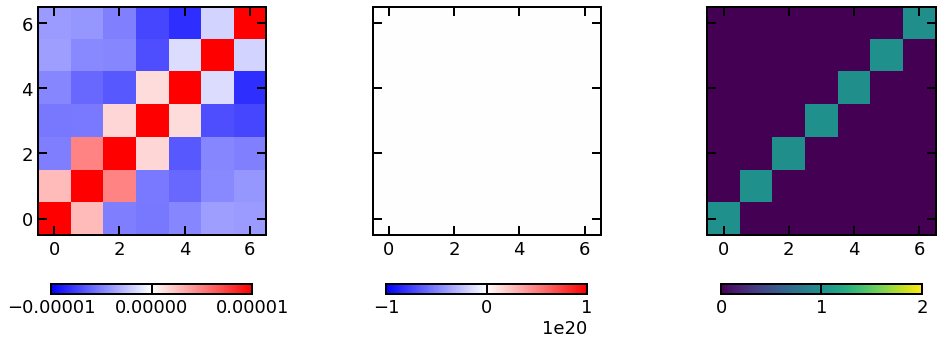

In [157]:
covmax_ = covmax[:7, :7]
invcov_ = np.linalg.inv(covmax_)


fg, ax = plt.subplots(ncols=3, figsize=(18, 6), sharey=True)
fg.subplots_adjust(wspace=0.0, hspace=0.0)

map0 = ax[0].imshow(covmax_, origin='lower', cmap=plt.cm.bwr, vmin=-1.0e-5, vmax=1.0e-5)
fg.colorbar(map0, ax=ax[0], orientation='horizontal', ticks=[-1.0e-5, 0, 1.0e-5], shrink=0.6)

map1 = ax[1].imshow(invcov_, origin='lower', cmap=plt.cm.bwr, vmin=-1.0e20, vmax=1.0e20, )
fg.colorbar(map1, ax=ax[1], orientation='horizontal', ticks=[-1.0e+20, 0, 1.0e+20], shrink=0.6)


map2 = ax[2].imshow(covmax_.dot(invcov_), origin='lower', cmap=plt.cm.viridis, vmin=0, vmax=2.0)
fg.colorbar(map2, ax=ax[2], orientation='horizontal', ticks=[0., 1, 2.0], shrink=0.6)


In [158]:
np.linalg.matrix_rank(covmax)

91

In [172]:
for i in range(13):
    cov_ = covmax[8*i:8*i+8, 8*i:8*i+8]
    print(i, np.linalg.det(cov_), np.linalg.matrix_rank(cov_))

0 -3.6187293702437014e-54 7
1 1.6978008880321082e-54 7
2 9.470416264603769e-56 7
3 -1.0094638383427854e-56 7
4 1.3099878852499306e-55 7
5 -1.853566265894692e-55 7
6 2.2460863841782073e-56 7
7 4.478450491820408e-56 7
8 -6.163690828115977e-53 7
9 2.477181620475782e-52 7
10 -1.2872990813929492e-54 7
11 7.093463284823898e-55 7
12 -5.773014444890049e-56 7


In [129]:
covmax.shape[0]//8

11

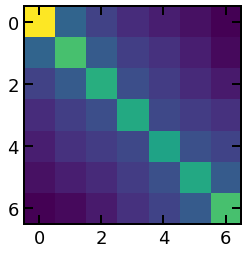

In [130]:
plt.imshow(cov_)

In [164]:
chi2_fn(err_0, invcov), chi2_fn(err_1, invcov)

(294.7361706954772, 71.0266254194938)

In [160]:
chi2_fn(err_0, invcov), chi2_fn(err_1, invcov)

(294.8121197373846, 71.03065368739993)

In [88]:
err_min, err_max = np.percentile(err_mat, [0, 100], axis=0)

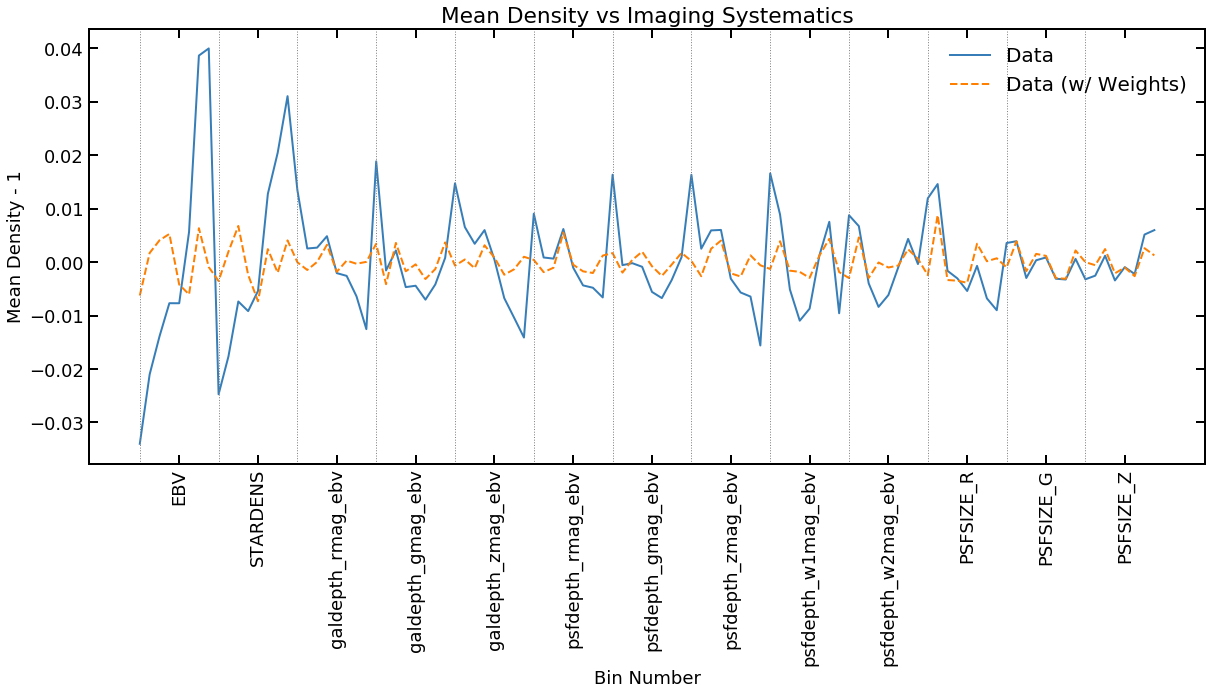

In [33]:
plt.figure(figsize=(20, 8))
plt.plot(err_0, color='C0', label='Data', lw=2, zorder=-1)
plt.plot(err_1, color='C1', ls='--', label='Data (w/ Weights)', lw=2)

#for err_mi in err_mat:
#    plt.plot(err_mi, color='C1', alpha=0.1, zorder=-2)
# plt.fill_between(np.arange(err_min.size), err_min, err_max, color='C1', alpha=0.2)

plt.xlabel('Bin Number')
plt.ylabel('Mean Density - 1')
plt.title('Mean Density vs Imaging Systematics')
plt.legend(fontsize=20)
_=plt.xticks([i*8+4 for i in range(13)], labels=maps_dr9, rotation=90)
for i in range(13):
    plt.axvline(i*8, ls=':', color='grey', lw=1)
# plt.ylim(-0.02, 0.02)

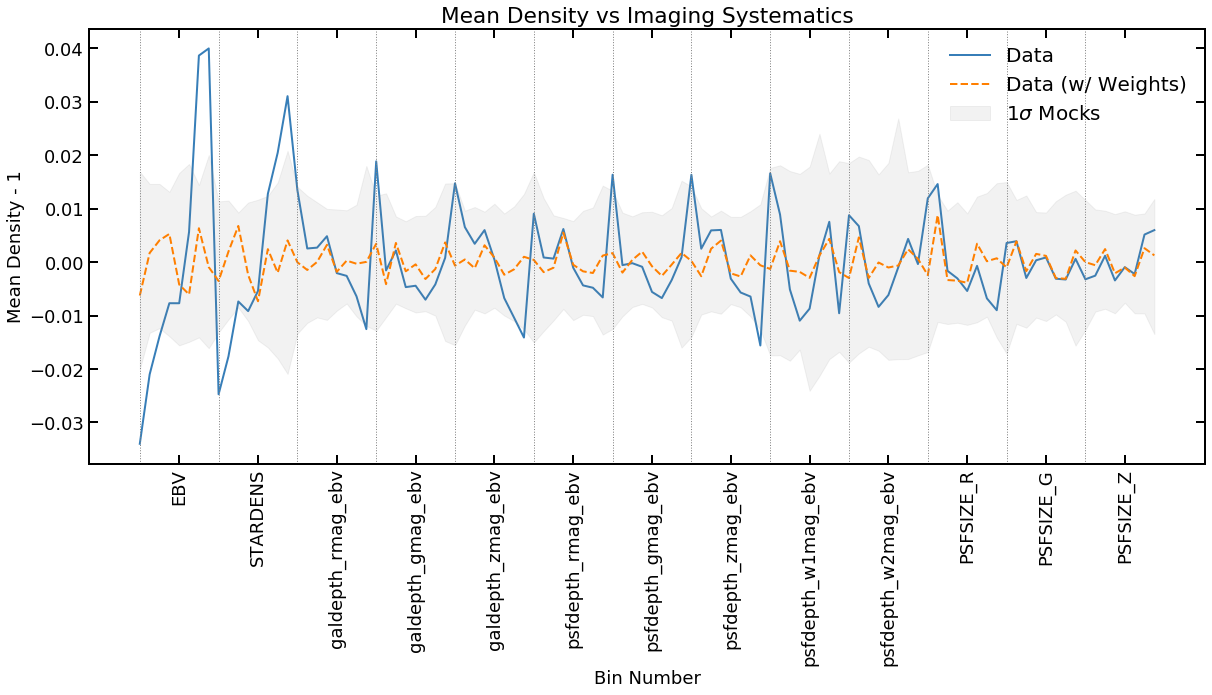

In [36]:
plt.figure(figsize=(20, 8))
plt.plot(err_0, color='C0', label='Data', lw=2, zorder=-1)
plt.plot(err_1, color='C1', ls='--', label='Data (w/ Weights)', lw=2)

#for err_mi in err_mat:
#    plt.plot(err_mi, color='C1', alpha=0.1, zorder=-2)
plt.fill_between(np.arange(err_min.size), err_min, err_max, color='grey', alpha=0.1, 
                label=r'$1\sigma$ Mocks')

plt.xlabel('Bin Number')
plt.ylabel('Mean Density - 1')
plt.title('Mean Density vs Imaging Systematics')
plt.legend(fontsize=20)
_=plt.xticks([i*8+4 for i in range(13)], labels=maps_dr9, rotation=90)
for i in range(13):
    plt.axvline(i*8, ls=':', color='grey', lw=1)
# plt.ylim(-0.02, 0.02)

In [92]:
err_scale = err_mat - err_mat.mean(axis=0)

In [95]:
covs = np.cov(err_scale, rowvar=False)

In [96]:
invcovs = np.linalg.inv(covs)

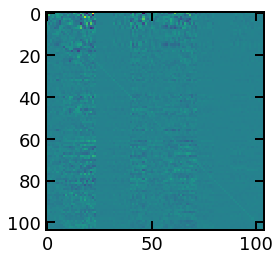

In [98]:
plt.imshow(covs.dot(invcovs))

In [36]:
d0 = np.load(list_nbars[0], allow_pickle=True)
d1 = np.load(list_nbars[10], allow_pickle=True)

In [37]:
d0[0]

{'nnbar': array([0.99585615, 1.00197567, 0.99586151, 1.00315507, 1.00664504,
        0.9914709 , 1.00287094, 1.00216488]),
 'area': array([12222., 12222., 12222., 12222., 12222., 12222., 12222., 12221.]),
 'nnbar_err': array([0.00296832, 0.00223668, 0.00280899, 0.00262396, 0.00251104,
        0.00167031, 0.00294963, 0.00239442]),
 'bin_edges': array([0.00367896, 0.01166427, 0.01457686, 0.01783316, 0.02281092,
        0.03234769, 0.04577622, 0.06690618, 0.41883251]),
 'bin_avg': array([0.00951587, 0.01314601, 0.01615297, 0.02008719, 0.02713269,
        0.03881256, 0.05500321, 0.10328343]),
 'attr': {'njack': 20, 'nbar': 30.524377397085143, 'npix2area': 1.0},
 'sys': 'EBV'}

In [38]:
d1[0]

{'nnbar': array([0.99679299, 1.00678415, 0.99902492, 0.99694914, 1.00104684,
        1.00213992, 0.9989253 , 0.9983366 ]),
 'area': array([12222., 12222., 12222., 12222., 12222., 12222., 12222., 12221.]),
 'nnbar_err': array([0.00309704, 0.00221506, 0.00235517, 0.00261592, 0.00255848,
        0.00312274, 0.002693  , 0.00330425]),
 'bin_edges': array([0.00367896, 0.01166427, 0.01457686, 0.01783316, 0.02281092,
        0.03234769, 0.04577622, 0.06690618, 0.41883251]),
 'bin_avg': array([0.00951587, 0.01314601, 0.01615297, 0.02008719, 0.02713269,
        0.03881256, 0.05500321, 0.10328343]),
 'attr': {'njack': 20, 'nbar': 30.390130401431858, 'npix2area': 1.0},
 'sys': 'EBV'}

In [100]:
dd = np.load('/home/mehdi/data/rongpu/imaging_sys/clustering/v2/nbar_lrg_bmzls_256_nn.npy', allow_pickle=True)
dd[0]

{'nnbar': array([0.99375002, 1.00171952, 1.00407873, 1.00527443, 0.99580699,
        0.9939571 , 1.00634445, 0.99906858]),
 'area': array([12221.93515835, 12222.77626307, 12222.22381377, 12221.98880691,
        12222.91208552, 12222.19999904, 12222.26856452, 12218.69530881]),
 'nnbar_err': array([0.00400074, 0.0025467 , 0.00222308, 0.00226435, 0.00331056,
        0.00136965, 0.00253457, 0.00172797]),
 'bin_edges': array([0.00367896, 0.01155863, 0.01439689, 0.01749723, 0.02209954,
        0.03091424, 0.04398893, 0.06449677, 0.41883251]),
 'bin_avg': array([0.00943713, 0.01300348, 0.01589296, 0.01956954, 0.0260189 ,
        0.03723095, 0.05299107, 0.0991519 ]),
 'attr': {'njack': 20,
  'nbar': 1.0003323740528882,
  'npix2area': 1.0982169373903181},
 'sys': 'EBV'}

In [33]:
maps_dr9 = ['EBV', 'STARDENS']\
          + [f'galdepth_{b}mag_ebv' for b in ['r', 'g', 'z']]\
          + [f'psfdepth_{b}mag_ebv' for b in ['r', 'g', 'z', 'w1', 'w2']] \
          + [f'PSFSIZE_{b}' for b in ['R', 'G', 'Z']]
for i, mapi in enumerate(maps_dr9):
    print(i, mapi)

0 EBV
1 STARDENS
2 galdepth_rmag_ebv
3 galdepth_gmag_ebv
4 galdepth_zmag_ebv
5 psfdepth_rmag_ebv
6 psfdepth_gmag_ebv
7 psfdepth_zmag_ebv
8 psfdepth_w1mag_ebv
9 psfdepth_w2mag_ebv
10 PSFSIZE_R
11 PSFSIZE_G
12 PSFSIZE_Z


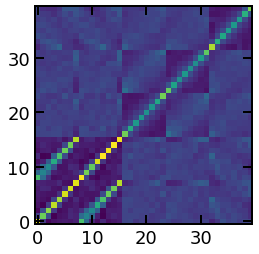

In [27]:
plt.imshow(covmax[8*8:,8*8:], origin='lower')

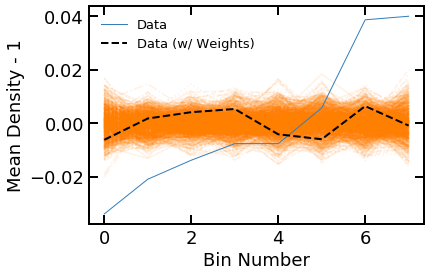

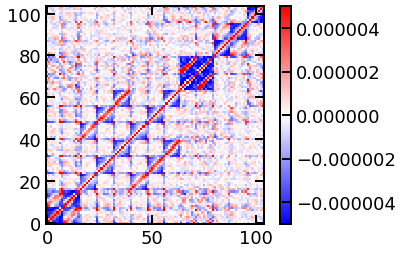

In [7]:
plt.imshow(errcov*hartlapf, origin='lower', 
           cmap=plt.cm.bwr, vmin=-5.0e-6, vmax=5.0e-6)
plt.colorbar()

8.0

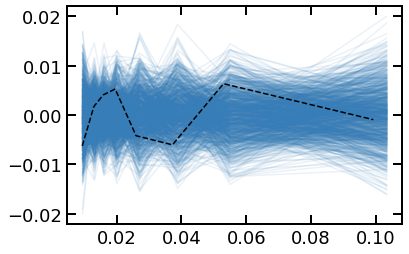

In [101]:
for nbar_i in list_nbars:
    d_i = np.load(nbar_i, allow_pickle=True)[0]
    
    plt.plot(d_i['bin_avg'], d_i['nnbar']-1, ls='-', color='C0', alpha=0.1)    
    
plt.plot(dd[0]['bin_avg'], dd[0]['nnbar']-1, 'k--')

In [ ]:
#---- Next

# create ensemble of full sky log-normal mocks
# check if the observed data cell agrees with the mock dispersion on high-ell (ell > 20)?
# split into BASS / DECaLS North / DECaLS South
# measure C_ell, mean density, etc 
# construct covariance matrices
# test for remaining systematics,
# create non-zero fNL mocks, something close to yield the observed C_ell after mitigation


# keep in mind
# look at the nbar after the mitigation
# make sure high ell of the data matches that of the input model to FLASK
# adjust the maximum volume density